# **UEFA EURO DATA**

---

**NOTEBOOK 1: UEFA EURO DATA COLLECTION AND PRE-PROCESSING**

---

**AUTHOR**

---



- Elmander

**TABLE OF CONTENT**

---



1.   STEP 1: SCRAPING.

     STEP 1 - PHASE 1: Creating Direct Download API.

     STEP 1 - PHASE 2: Extracting Downloaded Zipped Data.

2.   STEP 2: PRE-PROCESSING.

     STEP 2 - PHASE 1A: Managing Date-Time Values and Range.

     STEP 2 - PHASE 1B: Filtering Teams for Relevant Competition.

     STEP 2 - PHASE 2A: Calculating Winning Teams.

     STEP 2 - PHASE 2B: Label Encoding Data.

     STEP 2 - PHASE 3: Removing Outliers.

     STEP 2 - PHASE 4: Saving Clean Data.


**PROBLEM STATEMENT**

---



- Acquisition of UEFA Euro data for Data Analysis.
- Preparation of UEFA Euro data for Machine Learning.

**SOLUTION**

---



- We are going to use the following schematic to guide us on our work.

---

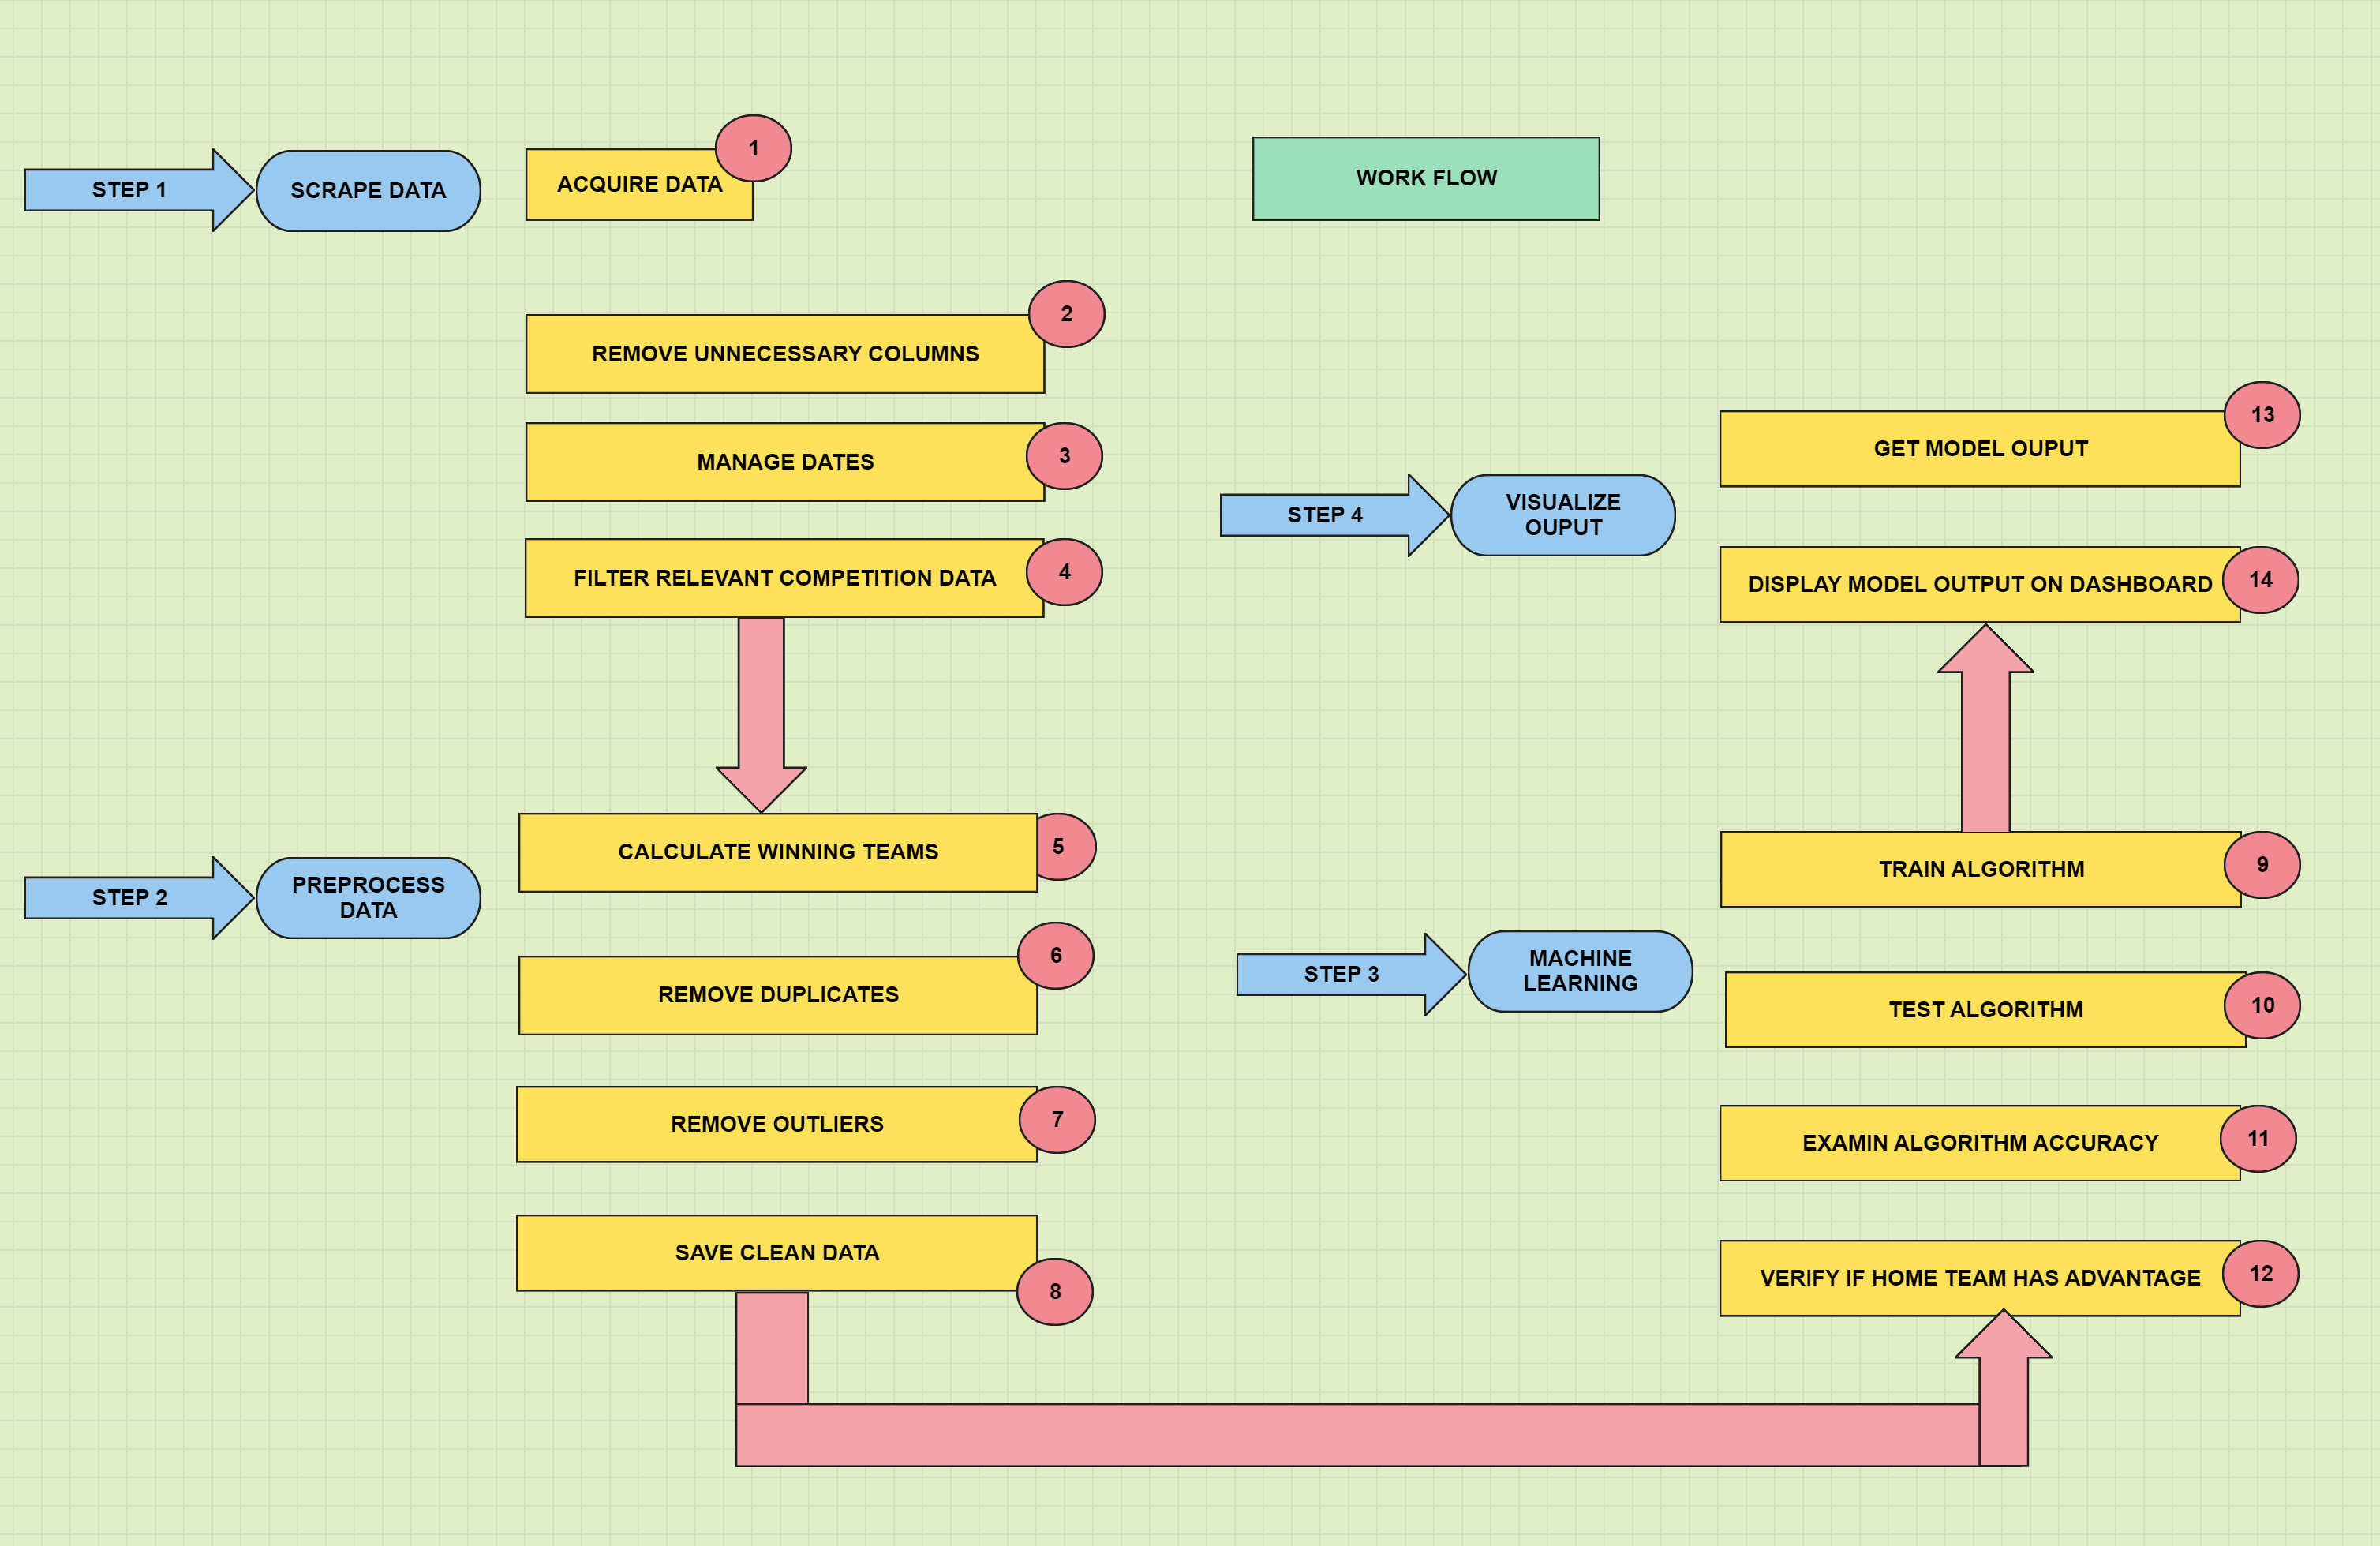

---

**REFERENCES**

---

For more information about the datasets used in this notebook, read the full documentation through the following links;

**DOCUMENT 1**: [GITHUB DATA](https://github.com/martj42/international_results)

**DOCUMENT 2**: [KAGGLE DATA](https://www.kaggle.com/datasets/martj42/international-football-results-from-1872-to-2017?select=results.csv)

**TO DO LIST**

---

1. Create Direct Download API. ✅
2. Extract Downloaded Zipped Data. ✅
3. Manage Date-Time Values. ✅
4. Manage Date-Time Range. ✅
5. Filter Relevant Teams and Competitions. ✅
6. Calculate Winning Teams. ✅
7. Label Encode Data. ✅
8. Remove Outliers. ✅
9. Save Clean Data. ✅
10. Publish on DagsHub. ✅

---

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import requests, os, zipfile, shutil
from pandas.errors import ParserError
from sklearn.preprocessing import LabelEncoder

In [2]:
def download_from_url(url, filename, save_directory):
    response = requests.get(url)
    if response.status_code == 200:
        # Save the zip file
        zip_path = os.path.join(save_directory, filename)
        with open(zip_path, 'wb') as file:
            file.write(response.content)
        print(f"Downloaded {filename} and saved in {save_directory}")

        # Extract the zip file
        extract_dir = os.path.join(save_directory, filename.split('.')[0])
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)

        # Delete the zip file
        os.remove(zip_path)

        # Move the 'results.csv' file to the save directory
        results_path = os.path.join(extract_dir, 'international_results-master', 'results.csv')
        if os.path.exists(results_path):
            shutil.move(results_path, save_directory)
            print(f"Moved 'results.csv' to {save_directory}")
        else:
            print(f"'results.csv' not found in {extract_dir}")

        # Delete all files and folders within the extract directory
        shutil.rmtree(extract_dir)

        # Delete all other files and folders within the save directory except 'results.csv'
        for root, dirs, files in os.walk(save_directory):
            for file in files:
                if file != 'results.csv':
                    os.remove(os.path.join(root, file))
            for dir in dirs:
                shutil.rmtree(os.path.join(root, dir))
    else:
        print(f"Failed to download {filename}")

In [3]:
# Define the URL and filename
url = 'https://github.com/martj42/international_results/archive/refs/heads/master.zip'
filename = 'master.zip'

# Define the directory to save the files
save_directory = "Data/annual-data/"

# Ensure the save directory exists
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

# Download and process the zip file
download_from_url(url, filename, save_directory)

Downloaded master.zip and saved in Data/annual-data/
Moved 'results.csv' to Data/annual-data/


In [4]:
# Load the data
data = pd.read_csv('Data/annual-data/results.csv')

# Remove empty rows and columns
data = data.dropna(how='all')
data = data.dropna(axis=1, how='all')

# Convert the 'date' column to datetime
data['date'] = pd.to_datetime(data['date'], dayfirst=True)

# Sort by 'date' column in descending order (newest first)
data = data.sort_values(by='date', ascending=False)

# Reset the index
data = data.reset_index(drop=True)

# Change the date format to 'DD/MM/YYYY'
data['date'] = data['date'].dt.strftime('%d/%m/%Y')

# Display the first few rows
print(data.head(5))

C:\Users\elmer\AppData\Local\Temp\ipykernel_3916\2829086645.py:9: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  data['date'] = pd.to_datetime(data['date'], dayfirst=True)


         date home_team away_team  home_score  away_score    tournament  \
0  14/07/2024       NaN       NaN         NaN         NaN  Copa América   
1  14/07/2024       NaN       NaN         NaN         NaN     UEFA Euro   
2  13/07/2024       NaN       NaN         NaN         NaN  Copa América   
3  10/07/2024       NaN       NaN         NaN         NaN  Copa América   
4  10/07/2024       NaN       NaN         NaN         NaN     UEFA Euro   

            city        country  neutral  
0  Miami Gardens  United States     True  
1         Berlin        Germany     True  
2      Charlotte  United States     True  
3      Charlotte  United States     True  
4       Dortmund        Germany     True  


In [5]:
# Parse the Date column
data['date'] = pd.to_datetime(data['date'], format='%d/%m/%Y', dayfirst=True)

# Define the date range
start_date = '01/08/1950'
end_date = '31/07/2024'

# Filter the DataFrame based on the date range
data = data[(data['date'] >= start_date) & (data['date'] <= end_date)]

# Sort the DataFrame by 'Date' in descending order
data = data.sort_values(by='date', ascending=False)

# Strip whitespace from the 'tournament' column
data['tournament'] = data['tournament'].str.strip()

# Select matches only from the African Cup of Nations tournament
data = data[data['tournament'].isin(['UEFA Euro'])]

# Calculate goal difference and add it as a new column
data['GoalDifference'] = data['home_score'] - data['away_score']

# Create the 'winner' column based on the goal difference
data['FTR'] = data['GoalDifference'].apply(lambda x: 'H' if x > 0 else ('A' if x < 0 else 'D'))

# Rename the columns
data.rename(columns={'date': 'Date', 'home_team': 'HomeTeam', 'away_team': 'AwayTeam', 'home_score': 'FTHG', 'away_score': 'FTAG', 'tournament': 'Tournament', 'city': 'CityVenue', 'country': 'CountryVenue', 'neutral': 'VenueNeutrality'}, inplace=True)

# Select the columns of interest
columns_of_interest = ['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'GoalDifference', 'FTR', 'Tournament', 'CityVenue', 'CountryVenue', 'VenueNeutrality']
data = data[columns_of_interest]
data.tail(5)

Date        HomeTeam        AwayTeam  FTHG  FTAG  GoalDifference  \
41339 1964-06-17         Denmark          Russia   0.0   3.0            -3.0   
42328 1960-07-10          Russia      Yugoslavia   2.0   1.0             1.0   
42330 1960-07-09          France  Czechoslovakia   0.0   2.0            -2.0   
42332 1960-07-06  Czechoslovakia          Russia   0.0   3.0            -3.0   
42333 1960-07-06          France      Yugoslavia   4.0   5.0            -1.0   

      FTR Tournament  CityVenue CountryVenue  VenueNeutrality  
41339   A  UEFA Euro  Barcelona        Spain             True  
42328   H  UEFA Euro      Paris       France             True  
42330   A  UEFA Euro  Marseille       France            False  
42332   A  UEFA Euro  Marseille       France             True  
42333   A  UEFA Euro      Paris       France            False

In [6]:
# Drop the GoalDifference column such that it doesn't disturb future goal difference calculations
data.drop('GoalDifference', axis=1, inplace=True)

# Initialize the label encoder
label_encoder = LabelEncoder()

# Here, we'll just drop any rows that contain missing values
data.dropna(inplace=True)

# Here, we'll just drop duplicate rows
data.drop_duplicates(inplace=True)

# Convert 'HTR' and 'FTR' to numeric values
data['FTR'] = label_encoder.fit_transform(data['FTR'])
print(label_encoder.classes_)

['A' 'D' 'H']


In [7]:
# Calculate mean and standard deviation of FTHG and FTAG
mean_fthg = data['FTHG'].mean()
std_fthg = data['FTHG'].std()
mean_ftag = data['FTAG'].mean()
std_ftag = data['FTAG'].std()

# Define a threshold for outliers (e.g., 3 standard deviations from the mean)
threshold_fthg = 3 * std_fthg
threshold_ftag = 3 * std_ftag

# Filter out rows where FTHG or FTAG is beyond the threshold
filtered_data = data[(np.abs(data['FTHG'] - mean_fthg) <= threshold_fthg) & (np.abs(data['FTAG'] - mean_ftag) <= threshold_ftag)]

# Let's check how many rows were removed as outliers
outliers_removed = len(data) - len(filtered_data)
print(f"Number of outliers removed: {outliers_removed}")

# Also remove outliers using quantiles 
def outliers(data, feature):
    Q1= data[feature].quantile(0.25)
    Q3 = data[feature].quantile(0.75)
    IQR = Q3 - Q1
    upper_limit = Q3 + 1.5 * IQR
    lower_limit = Q1 - 1.5 * IQR
    return upper_limit, lower_limit
upper, lower = outliers(data, "FTHG")
upper, lower = outliers(data, "FTAG")
print("Upper whisker: ", upper)
print("Lower Whisker: ", lower)

Number of outliers removed: 9
Upper whisker:  5.0
Lower Whisker:  -3.0


In [8]:
# Removing outliers on the <<FTHG>> column
data[(data['FTHG'] < lower) | (data['FTHG'] > upper)]

Date     HomeTeam AwayTeam  FTHG  FTAG  FTR Tournament  CityVenue  \
22746 2000-06-25  Netherlands   Serbia   6.0   1.0    2  UEFA Euro  Rotterdam   

      CountryVenue  VenueNeutrality  
22746  Netherlands            False

In [9]:
# Removing outliers on the <<FTAG>> column
data[(data['FTAG'] < lower) | (data['FTAG'] > upper)]

Empty DataFrame
Columns: [Date, HomeTeam, AwayTeam, FTHG, FTAG, FTR, Tournament, CityVenue, CountryVenue, VenueNeutrality]
Index: []

In [10]:
# Save the cleaned data
output_path = 'Data/clean-data/clean-data.csv'
os.makedirs(os.path.dirname(output_path), exist_ok=True)
data.to_csv(output_path, index=False)
data.head(5)

Date  HomeTeam        AwayTeam  FTHG  FTAG  FTR Tournament  \
75 2024-06-19   Croatia         Albania   2.0   2.0    1  UEFA Euro   
77 2024-06-19   Germany         Hungary   2.0   0.0    2  UEFA Euro   
76 2024-06-19  Scotland     Switzerland   1.0   1.0    1  UEFA Euro   
78 2024-06-18  Portugal  Czech Republic   2.0   1.0    2  UEFA Euro   
79 2024-06-18    Turkey         Georgia   3.0   1.0    2  UEFA Euro   

    CityVenue CountryVenue  VenueNeutrality  
75    Hamburg      Germany             True  
77  Stuttgart      Germany            False  
76    Cologne      Germany             True  
78    Leipzig      Germany             True  
79   Dortmund      Germany             True